In [11]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [12]:
data_storage = 'D:/Data/taxi/' # путь, где хранятся данные о поездках

Для начала пробуем запустить данные как есть, заодно посмотрим сколько занимает памяти.

In [5]:
%%time
data = pd.read_csv(data_storage+'yellow_tripdata_2016-05.csv')
print('Использовано памяти: {:.2f}'.format(data.memory_usage().sum() / 1024**2))

Использовано памяти: 1715.85
Wall time: 27.2 s


Учитывая, что данный файл может быть не самого большого размера, то могут возникнуть проблемы при работе с ними, особенно когда надо будет обрабатывать много файлов. Попробуем оптимизировать чтение файлов. Для агрегирования по времени и региону, нам не нужны все данные. Достаточно только время начала и конца поездки, координаты региона, ну и так же признаки по которым будем фильтровать данные (trip_distance и passenger_count). Так же можно преобразовывать данные в менее затратные по памяти формат (однако здесь нужно быть аккуратным, поскольку при изменении формата, могут быть погрешности, поэтому данные со значениями такие как координаты, лучше не трогать). Создадим словарь в котором явно зададим в каком формате будем хранить. 

In [13]:
dtype_col = {'passenger_count': 'uint8',
             'trip_distance': 'float32'}
NY_border={'W': -74.25559, 'E': -73.70001, 'S': 40.49612, 'N': 40.91553}

При чтении так же оставим возможность получить полный датасет, если он вдруг нам понадобится в дальнейшем. Также включим сюда фильтрацию согласно заданию, а именно:

Проведите фильтрацию: удалите поездки с

- нулевой длительностью
- нулевым количеством пассажиров
- нулевым расстоянием поездки по счётчику
- координатами начала, не попадающими в прямоугольник Нью-Йорка

In [14]:
def data_loader(file_name, filt=True, all_data=False, use_cols=[1,2,3,4,5,6], border=NY_border):
    month_name = file_name[-11:-4] # сохраним название месяца из названия файла для дальнейшего использования
    if not all_data:
        taxi = pd.read_csv(file_name, usecols=[1,2,3,4,5,6], dtype=dtype_col)
        print('Использовано памяти: {:.2f}'.format(taxi.memory_usage().sum() / 1024**2))
    else:
        taxi = pd.read_csv(file_name, dtype=dtype_col)
    
    if not filt:
        return taxi
    else:
        taxi.dropna(inplace=True) # на случай если где либо появятся nan 
        taxi = taxi[(taxi['pickup_longitude']>=NY_border['W'])&(taxi['pickup_longitude']<=NY_border['E'])]
        taxi= taxi[(taxi['pickup_latitude']>=NY_border['S'])&(taxi['pickup_latitude']<=NY_border['N'])]
        
        taxi = taxi[taxi['trip_distance']!=0]
        
        taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
        taxi['tpep_dropoff_datetime'] = pd.to_datetime(taxi['tpep_dropoff_datetime'])
        
        taxi = taxi[taxi['tpep_pickup_datetime'] != taxi['tpep_dropoff_datetime']]
        
        taxi['tpep_pickup_datetime'] = taxi['tpep_pickup_datetime'].dt.floor("H")
        
        taxi = taxi[taxi['passenger_count']!=0]
        
        print(taxi.shape)
        
        return taxi, month_name
        

In [15]:
%%time
df, m_name = data_loader(data_storage+'yellow_tripdata_2016-05.csv')

Использовано памяти: 417.67
(11626521, 6)
Wall time: 30.9 s


Таким образом сократили используюмую память в 3 раза. Неплохо. Для написания следующих функций, нам понадобится подгрузить датасет regions. В рамках этого задания все что нужно из него уже получено, поэтому закомментируем его. 

In [16]:
# regions = pd.read_csv('data/regions.csv', sep=';')

def set_region(data, num=50, border=NY_border):
    step_long = (NY_border['E'] - NY_border['W'])/50
    step_lat = (NY_border['N'] - NY_border['S'])/50
    
    long = np.floor((data['pickup_longitude'] - NY_border['W'])/step_long)
    lat = np.floor((data['pickup_latitude'] - NY_border['S'])/step_lat)
    
    data['region'] = long*num+lat + 1 # добавляем 1, что б соответствовало регионам из файла
    
    return data

def single_region(vec, num=50, border=NY_border):
    step_long = (NY_border['E'] - NY_border['W'])/50
    step_lat = (NY_border['N'] - NY_border['S'])/50
    
    long = np.floor((vec[0] - NY_border['W'])/step_long)
    lat = np.floor((vec[1] - NY_border['S'])/step_lat)
    
    return long*num+lat +1


Пишем функцию для получения агрегаций. 

In [17]:
def get_agg_data(data, month, regs=2500):
    hours = pd.Period(month).days_in_month*24
    binx, biny=np.linspace(0, hours, num=hours+1), np.linspace(1, regs+1, num=regs+1)
    data['hours'] = (data['tpep_pickup_datetime']-pd.to_datetime("2016-05-01 00:00:00", format='%Y-%m-%d %H:%M:%S'))/pd.Timedelta(hours=1)
    
    ind = pd.date_range(start=month, periods=hours, freq='h')
    
    agg_taxi = stats.binned_statistic_2d(data['hours'], data['region'], values=data['hours'],statistic='count', bins=[binx,biny]).statistic
    
    return pd.DataFrame(agg_taxi, index=ind, columns=range(1, regs+1))
    

Ну и заворачиваем все в единую функцию для пайплайна, с возможностью сохранять файлы. 

In [18]:
def pipeline_aggs(file_name, save=True, save_path=data_storage+'aggs/'):
    df, m_name = data_loader(file_name)
    df = set_region(df)
    aggs = get_agg_data(df, m_name)
    
    if save:
        aggs.to_csv(save_path+"taxi-"+m_name+".csv",index=False)

    return aggs

In [19]:
%%time
aggs = pipeline_aggs(data_storage+'yellow_tripdata_2016-05.csv')

Использовано памяти: 417.67
(11626521, 6)
Wall time: 26.7 s


In [20]:
aggs.shape

(744, 2500)

In [21]:
aggs.head(5)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Найдем регион содержащий Empire State Building и построим по нему график.

In [22]:
#Longitude of Empire State Building -73.985664
#Latitude of Empire State Building: 40.748441
ESB_long = -73.985664
ESB_lat  =  40.748441
ESB_reg = single_region([ESB_long, ESB_lat])
print(ESB_reg)

1231.0


In [23]:
aggs.iloc[:,int(ESB_reg)].max()

1556.0

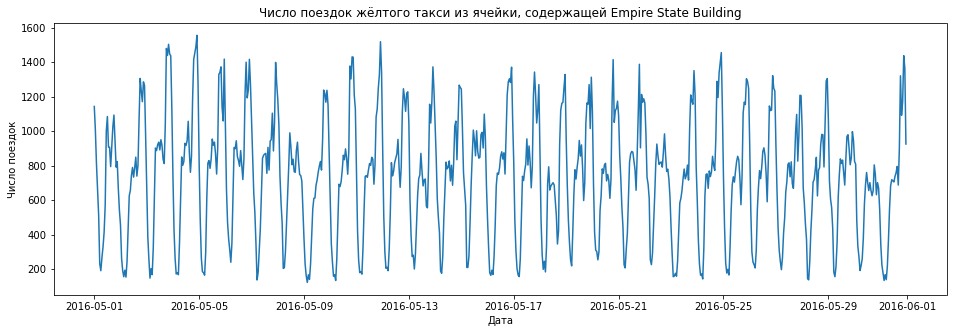

In [25]:
plt.figure(figsize=(16,5))
plt.plot(aggs.index, aggs.iloc[:,int(ESB_reg)], color='tab:blue')
plt.gca().set(title="Число поездок жёлтого такси из ячейки, содержащей Empire State Building", xlabel="Дата", ylabel="Число поездок")
plt.show()

Посчитаем число нулевых ячеек:

In [26]:
aggs.eq(0).sum().sum()

1718238